## Association subtypes emotion task

In [43]:
import seaborn as sns
import os
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [44]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [47]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_EMOTION_17-Jun-2017/';
path_association =  os.path.join(path_root,'associations/');
path_networks =  os.path.join(path_root,'networks/');

In [6]:
# List phenotypes
list_pheno  = [f for f in os.listdir(path_association)]
list_pheno = sorted(list_pheno)
list_pheno

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9']

In [17]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial = ['contrast_fear_vs_neut']

In [18]:
list_subtype = ['sub1','sub2','sub3','sub4','sub5']

In [19]:
# Create R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
        if ix == 0:
            pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_root,'{}_r2.csv'.format(trial_name)))

In [20]:
pheno_r2_final

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
sub1,0.006027,0.006289,0.008964,0.007272,0.008025,0.006232,0.007637,0.012152,0.013738
sub2,0.011515,0.019313,0.016420,0.027683,0.026316,0.016775,0.016839,0.019282,0.040360
sub3,0.010085,0.014189,0.014847,0.017748,0.017829,0.011729,0.013494,0.018289,0.028146
sub4,0.007349,0.015981,0.010550,0.022985,0.020203,0.014438,0.011631,0.011520,0.029086
sub5,0.008075,0.019623,0.012040,0.026198,0.022400,0.015769,0.012713,0.012891,0.031388


In [21]:
# first time on terminal install cairo : "sudo apt install libcairo2-dev" then "sudo apt-get install r-cran-stringr"
#devtools::install_github("hadley/svglite")
#devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)

In [22]:
%%R
library(ggradar)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

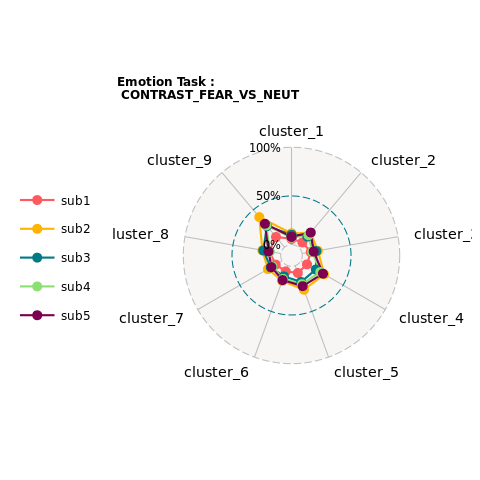

In [23]:
%%R -i path_root,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_root,ii,"_r2.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = 0,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Emotion Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_root,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

In [24]:
# plot association wieght and phenotypes
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        model_y =mat_load['model_raw']['y']
        model_x = mat_load['model_raw']['x']
        model_labels_x = mat_load['model_raw']['labels_x']
        model_labels_y = mat_load['model_raw']['labels_y']
        concat = [np.concatenate([model_y[x], model_x[x]]) for x in range(np.shape(model_y)[0])]
        model_df = pd.DataFrame(concat)
        model_df.index = model_labels_x
        colnames = np.concatenate([list_subtype,model_labels_y])
        model_df.columns = colnames
        model_df.to_csv(os.path.join(path_root,'{}_pheno_subtype.csv'.format(trial_name)))
        
        # plot association maps
        #for subtype in list_subtype:
        #    fig = plt.figure(figsize=(9,16))
        #    ax1 = fig.add_subplot(511)
        #    ax1 = sns.regplot(x=pheno_name, y=subtype, data=model_df,color="#BCB6FF");
        #    ax1.set_ylabel('{}_{}'.format(trial_name,subtype))
        #    ax1.set_xlabel(pheno_name)

In [25]:
os.path.join(path_root,'{}_pheno_subtype.csv'.format(trial_name))

'/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_EMOTION_17-Jun-2017/contrast_fear_vs_neut_pheno_subtype.csv'

## Random forest regressionn assocaition 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # read csv and manip tables 
import scipy.io #read .mat files
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR,LinearSVC
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle

In [27]:
model_df = model_df.reset_index().rename(columns={'index': 'Subject'})
model_df.head()

,Subject,sub1,sub2,sub3,sub4,sub5,FD_RL,FD_scrubbed_RL,FD_LR,FD_scrubbed_LR,...,Mother_ID,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,HCP100206,-0.122210,0.207483,-0.201525,0.316022,-0.287245,0.083053,0.083053,0.088776,0.088776,...,56037.0,-1.143794,1.304835,1.285918,-0.034336,0.205086,0.053396,0.090798,-0.512524,-0.118881
1,HCP100307,0.285930,0.379026,-0.418814,-0.077514,-0.255508,0.102121,0.102121,0.090372,0.090372,...,51488.0,-0.528411,0.493464,0.523816,-0.600763,0.386336,-0.953060,-0.958070,-0.143309,-0.722473
2,HCP100408,-0.126123,-0.517738,0.580187,-0.126164,0.352229,0.113475,0.113475,0.133985,0.133985,...,51730.0,-0.236296,0.020266,0.092588,0.114286,-0.084017,-0.522003,0.619392,0.219196,1.037169
3,HCP100610,0.103518,-0.211362,0.112771,0.064600,0.071578,0.158172,0.158172,0.174523,0.166174,...,52813.0,2.022214,0.895451,-0.361691,1.234488,0.709151,-0.882736,-0.323026,-0.199254,0.459399
4,HCP101006,0.349829,0.115661,-0.092004,-0.194501,-0.160362,0.132186,0.132186,0.117849,0.117849,...,51283.0,0.591952,-1.191472,0.037988,-0.682910,-0.516141,0.056823,-0.275139,-0.310782,0.308365


In [28]:
 # import all pheno data
all_pheno = pd.read_csv(os.path.join('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv'))

In [29]:
# set subject names with Prefix HCP
all_pheno.rename(columns={'Unnamed: 0': 'Subject'},inplace=True)
all_pheno['Subject'] = 'HCP'+ all_pheno['Subject'].astype(str)
all_pheno.head()

,Subject,Handedness,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100004,0.654367,-0.262795,0.706508,-0.038133,0.912634,0.543120,-1.133786,0.964184,0.526831,...,-0.560257,-0.137093,0.904230,0.582300,0.871791,-0.430821,-0.682838,1.605890,-0.312732,1.863197
1,HCP100206,-0.008896,-0.057218,-0.392537,-0.584901,0.249934,1.010833,0.415954,1.810203,0.732102,...,0.600528,1.133355,2.036441,1.148677,2.255963,1.506107,2.573747,2.101592,1.602519,0.819628
2,HCP100307,0.654367,-0.715064,-0.529918,-0.676029,-0.744115,-0.050883,0.863311,0.022050,0.116291,...,-0.560257,-0.681571,-0.888437,-0.323905,-0.685403,-0.624514,-0.682838,-0.707386,-0.660960,-0.432656
3,HCP100408,-0.229983,0.141209,1.874244,1.511043,-0.081415,1.057825,-0.360372,0.885089,-1.936414,...,0.407063,-0.681571,-0.982788,-0.210629,-0.685403,-0.430821,-0.682838,-0.707386,-0.660960,-0.432656
4,HCP100610,0.433279,1.778676,1.118650,-0.220389,-0.081415,-0.166160,1.454289,1.420734,1.347913,...,-0.753721,-0.137093,0.432475,-0.323905,-0.685403,-0.624514,-0.682838,2.597294,-0.835073,-0.641370


In [30]:
# Merge al pheno with subttyp weights
all_pheno_pruned = pd.merge(model_df[['Subject','sub1','sub2','sub3','sub4','sub5','FD_scrubbed_mean']],all_pheno,on='Subject',how='left')
# Drop NaN
all_pheno_pruned.dropna(inplace=True)

In [39]:
# Set data X Y
data_X = all_pheno_pruned.drop(['Subject','sub1','sub2','sub3','sub4','sub5'],axis=1)
#mask = feature_importances >= np.percentile(mean_feimp,feimp_thresh)
#data_X = data_X[data_X.columns[mask]]
data_Y = all_pheno_pruned['sub5']
y = data_Y.values
scl = StandardScaler()
y = scl.fit_transform(y.reshape(-1, 1))

minmiax = MinMaxScaler(feature_range=(-1, 1))
y = minmiax.fit_transform(y)[:,0]

x =data_X.values
scl = StandardScaler()
x = scl.fit_transform(x)

x, y = shuffle(x, y, random_state=0)
# print shape
print('y shape:',y.shape)
print('x shape:',x.shape)

y shape: (778,)
x shape: (778, 67)


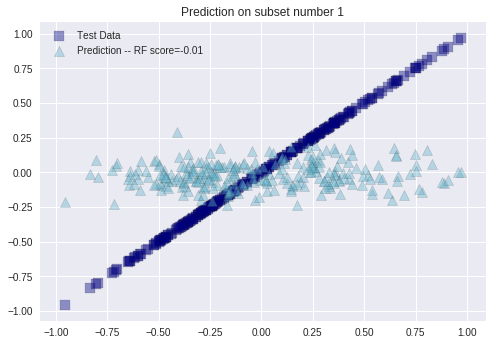

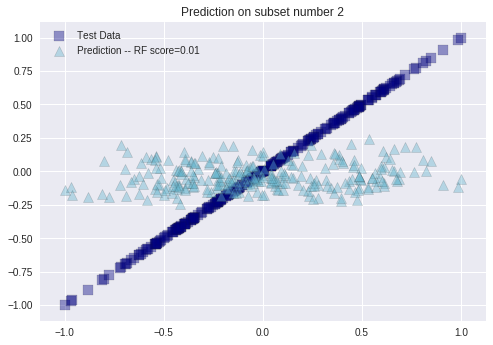

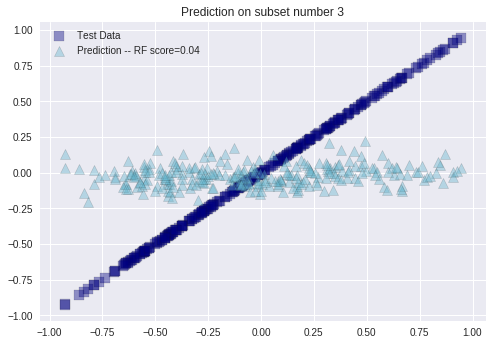

Mean R-squared : 0.0115383393056


In [40]:
# apply machine learning : Random forest regression
rfr = RandomForestRegressor(n_estimators=500,oob_score=True,n_jobs=-1)
skf = KFold(n_splits=3)
feimp_l = np.zeros((skf.n_splits,x.shape[1]))
scores = np.zeros((skf.n_splits,1))
std =  np.zeros((skf.n_splits,x.shape[1]))
c = 0
for train_index, test_index in skf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfr.fit(x_train, y_train)
    pred = rfr.predict(x_test)
    
    rsq = rfr.score(x_test, y_test)
    scores[c,:] = rsq
    
    feimp = rfr.feature_importances_
    feimp_l[c,:] = feimp[:]
    
    std[c,:] = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
    
    c+=1
    # Plot prediction
    #plt.figure()
    #plt.scatter(y_test,y_test,label='Test data')
    #plt.scatter(y_test,pred,label= 'Predicted data')
    #plt.title('R-squared :{}'.format(rsq))
    #print('R-squared :',rsq)
    #plt.plot(y_test, y_test,'bo', label='Test data')
    #plt.plot(y_test, pred, 'co', label='Predicted data')
    #plt.title('R-squared :{}'.format(rsq))
    #plt.legend()
    #plt.show()
    s = 100
    a = 0.4
    plt.figure()
    plt.scatter(y_test, y_test, edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Test Data")

    plt.scatter(y_test, pred, edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="Prediction -- RF score=%.2f" % rsq)
    plt.title("Prediction on subset number {}".format(c))
    plt.legend()
    plt.show()
print('Mean R-squared :',scores.mean())

In [41]:
# Threshold future importance
feimp_thresh = 0 # Percentile of future to be removed
mean_feimp = np.mean(feimp_l, axis=0)
mean_std = np.mean(std, axis=0)
feature_importances = pd.Series(mean_feimp,index= data_X.columns)
feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]

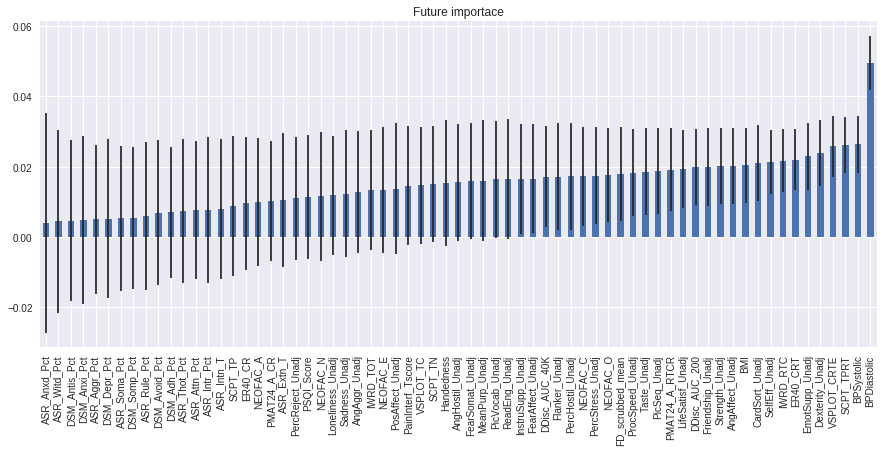

In [42]:
# Plot Future importance
feature_importances_select.sort()
feature_importances_select.plot(kind='bar',yerr=std_select[indices],figsize=(15,6),title='Future importace')